# Grids on Psi4

In [1]:
"""Tutorial explaining basic usage of grids in Psi4."""

__authors__ = "Victor H. Chavez"
__credits__ = "D. G. A. Smith"
__email__   = "gonza445@purdue.edu"

__copyright__ = "(c) 2014-2021, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "09/20/2020"

In [3]:
import psi4
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Modify matplotlib defaults
import matplotlib as mpl
mpl.rcParams["font.size"] = 14
mpl.rcParams["text.color"] = "grey"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9"

## 1. Overview. DFT Grid

This tutorial demonstrates how Psi4 uses a particular grids in DFT calculations to evaluate exchange-correlation functional approximations. These grids are designed to be accurate and efficient. They were not created to visualze scalar fields in space. For those purposes, other types of grids are used. Let us illustrate the different grids by using the **H**$_2$ molecule as an example. 

In [4]:
# Let's perform a regular Psi4 calculation.
h2 = psi4.geometry("""
h 0.0 0.0 -1.0
h 0.0 0.0  1.0
symmetry c1
units bohr
nocom
noreorient
""") 
# We're using atomic units throughout the tutorial. 
# Additional keywords ensure that the molecule stays where we defined it. 

# Don't forget to store the wavefunction and the basis set object. 
e, wfn = psi4.energy('hf/cc-pvdz', molecule=h2, return_wfn=True)
basis = wfn.basisset()

# Hartree-Fock calculations do not require a grid, but a DFT calculation does. 
# This is why we must additionally create a `SuperFunctional` object from scratch that will be used to create a `VBase` object. 
# Don't fret on not knowing these classes, we will go through their relevant methods as we move through the tutorial. 

functional = psi4.driver.dft.build_superfunctional("svwn", True)[0] # True states that we're working with a restricted system
Vpot       = psi4.core.VBase.build(basis, functional, "RV")         # This object contains different methods associated with DFT methods and the grid. 
                                                                    # "RV" states that this is a restricted system consystent with 'functional'
Vpot.initialize() # We initialize the object

# The grid (and weights) can then be extracted from Vpot.
x, y, z, w = Vpot.get_np_xyzw()


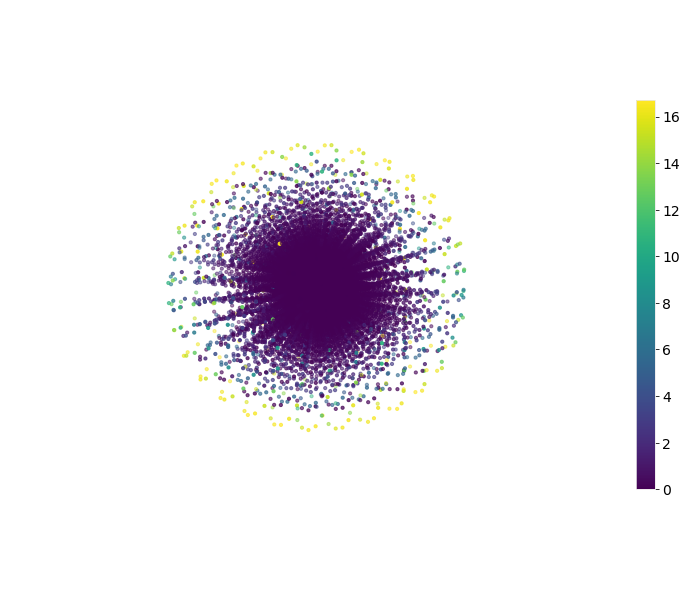

In [5]:
# Use matplotlib to visualize the grid. 
# We include the weights for each point for visualization purposes only. These values are required when integrating functions on this grid. 

fig = plt.figure(figsize=(9,8))
ax = Axes3D(fig)
ax.set_axis_off()
p = ax.scatter(x, y, z, c=w, s=10)
plt.colorbar(p, fraction=0.030, pad=0.04)

Although it appears to be quite intricate, the grid is built by tracing a set of spheres around each atom. To define a grid, two quantities are required: 1) a number of points per sphere and 2) a number of spheres around each atom. These can be set into Psi4 through the options "DFT_RADIAL_POINTS" and "DFT_SPHERICAL_POINTS". The default values are 302 and 75 respectively. The radial points can be any number positive number (typically 50-100), whereas the spherical points must be a very particular number ([Lebedev Points](https://psicode.org/psi4manual/master/dft.html#table-lebedevorder) = {6, 14, 26...}). These are the parameters that you will want to take a look every time you perform a DFT calcualtion.  
These are by far not the only options that affect the construction of the grid. For more detail information, visit the [grid selection section of the Psi4 manual](https://psicode.org/psi4manual/master/dft.html#grid-selection).


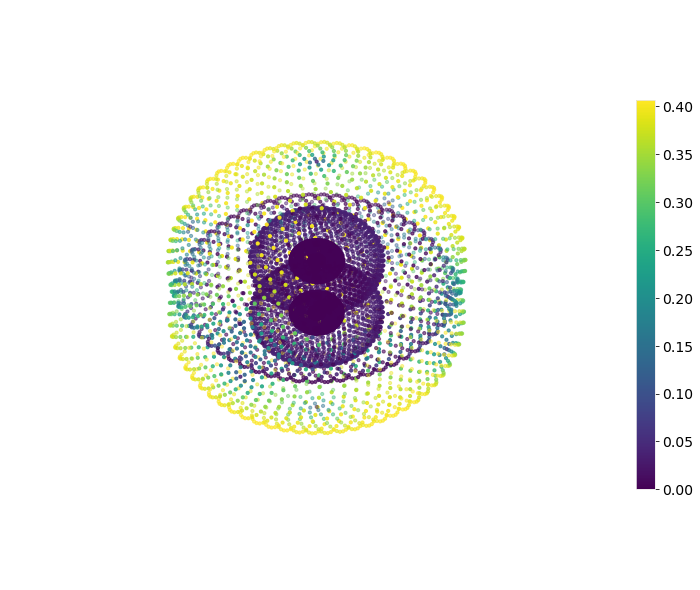

In [6]:
#Let's try to modify the default grid and visualize it again. 
psi4.set_options({"DFT_SPHERICAL_POINTS" : 1454,
                  "DFT_RADIAL_POINTS"    : 5})

Vpot.initialize()
x, y, z, w = Vpot.get_np_xyzw()

fig = plt.figure(figsize=(9,8))
ax = Axes3D(fig)
ax.set_axis_off()
p = ax.scatter(x, y, z, c=w, s=10)
plt.colorbar(p, fraction=0.030, pad=0.04)

# You should be able to distinguish the set of spheres now. Try modyfing the settings and see how they affect the distribution.

Although these grids are excellent for evaluating functionals and carrying different operations, they're not ideal to visualize some desired quantites, e.g. the electronic density. This is because they're very dense near the nuclei and very sparse far from them. Instead, you may have used the 'cube' file format. This file contains the same information, but the point distrubition is fairly different. It is composed of voxels, or values on a rectangular grid. 

Let us look under the hood and figure out how Psi4 can generate cube files. But instead of generating a text file we will simply store the points in a numpy array so that we can visualize it right here on the Notebook. 

--- 

# 2. Generating and expressing orbitals on a rectangular grid

The easiest quantity to generate on a rectangular grid are the molecular orbitals (MO). The set of molecular orbital can simply expressed in atomic orbitals (AO) in `p` points with:

$$ \phi_{\mu p} = \sum_{\nu} C_{\mu \nu} \cdot  \chi_{\nu p} \quad\quad\quad\quad (1)$$ 

Where instead of using $\vec{r}$, we are using `p`, the finite set of points where the function is represented. And the sum goes through each basis function. The $C\mu \nu$ in the previous equation is simply the output from our SCF calculation. Thus, the only thing needed to find our orbital in space, is to determine the value of the basis functions on the grid. 

### 2.1 Generate rectangular grid

Let's use python to generate an appropriate grid for our system. Our molecule **H**$_2$ has cylindrical symmetry. This means that any plane than contains the two atoms will represent the same information. Let's build a volume around the two atoms, later on we can slice this volume to find the plane of interest.


In [7]:
# Define the domain with numpy arrays. 
npoints = 31
z0 = np.linspace(-5, 5, npoints)
y0 = np.linspace(-5, 5, npoints)
x0 = np.linspace(-5, 5, npoints)

# These are one dimensional arrays. Let's use the function meshgrid to define all points in space. 
X,Y,Z = np.meshgrid(x0, y0, z0, indexing='ij')

# This creates a set of points spanning the volume that is of interested. Nevertheless, Psi4 does not handle grids in this way.
# Instead, the input requires an array arranged as (3, total_npoints). Thus we need to reshape and build into a new array. 
# We store the dimensions of the orginal arrays, since they will help us bring the points back to the shape we're interested in.

shape = (len(x0), len(y0), len(z0)) 
X     = X.reshape((X.shape[0] * X.shape[1] * X.shape[2], 1))
Y     = Y.reshape((Y.shape[0] * Y.shape[1] * Y.shape[2], 1))
Z     = Z.reshape((Z.shape[0] * Z.shape[1] * Z.shape[2], 1))
grid  = np.concatenate((X,Y,Z), axis=1).T

### 2.2 Generate blocks of points and points_function

Not only Psi4 requries the grid in a very particular way, but in order to perform some operations efficiently, Psi4 also fragments the points into blocks and stores them in an object called `BlockOPoints`. There are several parameters that define how many blocks and what point goes into what block. But for the purpose of the tutorial we're simply going to use the defaults of Psi4. In short, we're going to iterate over blocks and allocate a subset in a different `BlockOPoints`.



In [8]:
epsilon    = psi4.core.get_global_option("CUBIC_BASIS_TOLERANCE") # Cutoff for basis
max_points = psi4.core.get_global_option("DFT_BLOCK_MAX_POINTS")  # Maximum number of points per block
npoints    = grid.shape[1]                                        # Total number of points
extens     = psi4.core.BasisExtents(basis, epsilon)
nblocks    = int(np.floor(npoints/max_points))
remainder  = npoints - (max_points * nblocks)
blocks     = []

max_functions = 0

# Run through blocks
idx = 0 
inb = 0
for nb in range(nblocks+1):
    x = psi4.core.Vector.from_array(grid[0][idx : idx + max_points if inb < nblocks else idx + remainder])
    y = psi4.core.Vector.from_array(grid[1][idx : idx + max_points if inb < nblocks else idx + remainder])
    z = psi4.core.Vector.from_array(grid[2][idx : idx + max_points if inb < nblocks else idx + remainder])
    w = psi4.core.Vector.from_array(np.zeros(max_points))

    blocks.append( psi4.core.BlockOPoints(x, y, z, w, extens) )
    idx += max_points if inb < nblocks else remainder
    inb += 1
    max_functions = max_functions if max_functions > len(blocks[-1].functions_local_to_global()) \
                                                     else len(blocks[-1].functions_local_to_global())
    
    
points_func = psi4.core.RKSFunctions(basis, max_points, max_functions)
points_func.set_ansatz(0)
    

### 2.3 Compute Orbitals

In the previous cell, we collected a list of blocks and a 'points_function', which helps us compute the phi matrices. The following step is to generate subsets of the phi matrix and operate them with a subset of the C matrix. The result is then then placed in the orbital matrix. If you have trouble grasping the next cell, move ahead and everything will be further explained in tutorial 4b.  
A similar iteration is used when doing a DFT calculation to compute the exchange-correlation energy. The only differences is that the `Vpot` used will contain the a DFT grid, whereas in this tutorial, we manually created a rectangular grid. 
 

In [9]:
# Lets create a dictionary to store all of our orbitals
orbitals_p = np.zeros( (basis.nbf(), npoints) ) 

# And proceed just like we did with the LDA kernet tutorial. 
points_func.set_pointers( wfn.Da() )
Ca_np = np.array( wfn.Ca() )

offset = 0
for i_block in blocks:
    points_func.compute_points(i_block)
    b_points = i_block.npoints()
    offset += b_points
    lpos = np.array( i_block.functions_local_to_global() )
    
    if len(lpos) == 0:
        continue
        
    # Extract the subset of the Phi matrix. 
    phi = np.array(points_func.basis_values()["PHI"])[:b_points, :lpos.shape[0]]
    # Extract the subset of Ca as well
    Ca_local = Ca_np[(lpos[:, None], lpos)]
    # Store in the correct spot
    orbitals_p[lpos, offset - b_points : offset] = Ca_local.T @ phi.T

The resulting orbitals are no in `orbitals_p`. Although we're very close to achieving our goal, these are a few things that are worth thinking about.

1) Although the previous cell computes the orbitals, it can be quickly modified to also compute the density on the grid. Try to remember an equation that expresses the density using the basis sets and apply it to the algorithm. 

2) If you can compute the density from its atomic orbital representation, could you plug in another matrix, such as the external potential due to the nuclei (V) or the Coulomb potential (J)? Yes? No? Why? (You can always try it and convince yourself).

---


Before proceding, it is important to perform a sanity check. We need to verify that are indeed obtaining the orbitals that we are expecting. The quickest way to do so is by verifying that the density indeed contains the correct number of electrons. Thus we need to compute:

$$ \int \rho (\vec{r}) d\vec{r} = N \quad\quad\quad\quad (2)$$ 

Where N is the number of electrons. And we obtain the density from the occupied orbitals.

$$ \rho (\vec{r}) = \sum_{i}^{occ} | \phi_i( \vec{r} ) |^2 \quad\quad\quad\quad (3)$$  

Thus, for the case of **H**$_2$. The alpha density is generated from one orbital and we expect the density to integrate to one.



In [10]:
# In order to compute (2), we carry a simple numberical integration. For our current grid, the differential is simply our spacing cubed.  
diff = (x0[1]-x0[0])**3
rho  = np.abs( orbitals_p[0,:] ) ** 2

# And we can simply use the np.sum function to find the value of our integral. 
N = np.sum( rho * diff )

print(f"Our computed density has: {N} electrons")

Our computed density has: 0.9997843469426608 electrons


This appears to be correct! Although the number of electrons seems to be quite close, you should avoid making a calculations on this type of grid. For example, some density functional approximation or procedures that depend on the density, can be sensitive to small changes in density. Thus, if you require to operate things using a grid, use the spherical grids. Again, they can be quickly obtained from a `Vpot` object and the `points_function` (the Vpot object is always available from the wfn object after performing a DFT calculation).

---
# 3. Plot Orbitals

In [11]:
#Let us analize the points that we just obtained.

#How many points did we started with?
print("Total points in mesh", shape[0]*shape[1]*shape[2])

#How many points are in it?
print("Total points in the orbital", orbitals_p.shape)

Total points in mesh 29791
Total points in the orbital (10, 29791)


In [12]:
# We started with a domain of 29791 points, and we now have the value of the 10 orbitals at each of those same points! 
# Remember that the want the points to be arranged in a cubic array to visualize them. 
# We need to reshape the orbitals back to its original shape (This is why we stored the original shape)

orbitals = orbitals_p.reshape(10,shape[0],shape[1],shape[2])
print("New orbitals shape", orbitals.shape)

New orbitals shape (10, 31, 31, 31)


In order to visualize our orbitals, we can use the useful function from matplotlib called `imshow`. The function takes a two-dimensional array. We just need to select a slice of the volume defined by the last 3 dimensions of the array. We know that the two atoms are located on the z axis, so we can slice in the middle. Since we have 31 slices per dimension, we can use the 16th slice to find the closest plane to our system. 

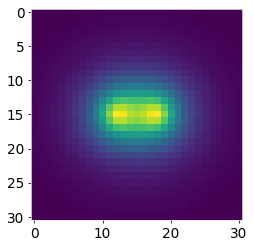

In [13]:
#Plot the orbital
fig, ax = plt.subplots(1,1, dpi=70)
plt.imshow(orbitals[0,16,:,:])

This doesn't look too good right now. Our current system is a very small molecule, so a finer grid should not require too much memory. But, if you have some experience with cube files, you should know that the size of them can become unmanageable pretty quickly. Because of this, `imshow` also has a feature that lets you interpolate between functions, so even if you're grid is not very fine, you will still get a smooth function. 

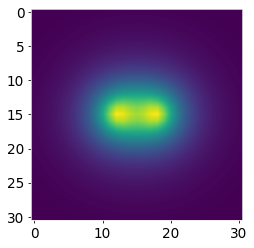

In [14]:
fig, ax = plt.subplots(1,1, dpi=70)
plt.imshow(orbitals[0,16,:,:], interpolation='bilinear')

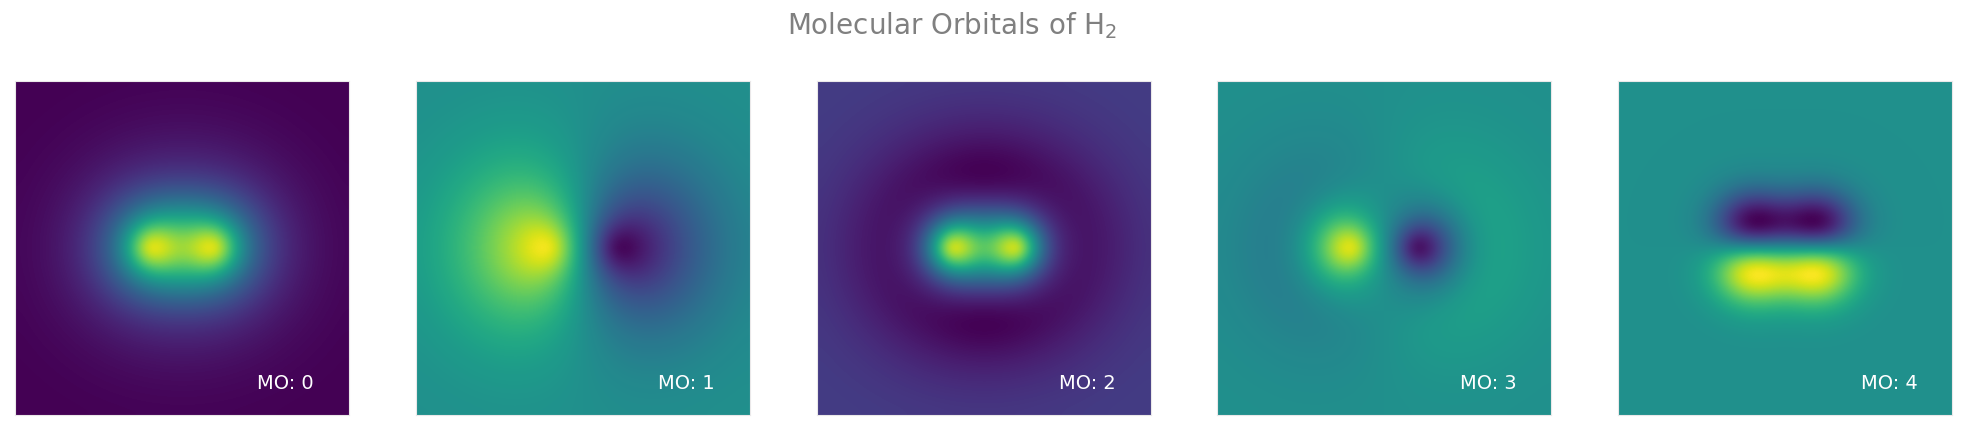

In [15]:
# We can now wrap everything up and show some orbitals together
fig, ax = plt.subplots( 1, 5, figsize=(25,5) , dpi=100)

fig.suptitle("Molecular Orbitals of H$_2$", fontsize=20)

for j, iax in enumerate(ax):
    iax.imshow(orbitals[j,16,:,:], interpolation='bicubic')
    iax.text(22,28, f"MO: {j}", color='white', fontsize=14)
    
    iax.set_xticks([])
    iax.set_yticks([])

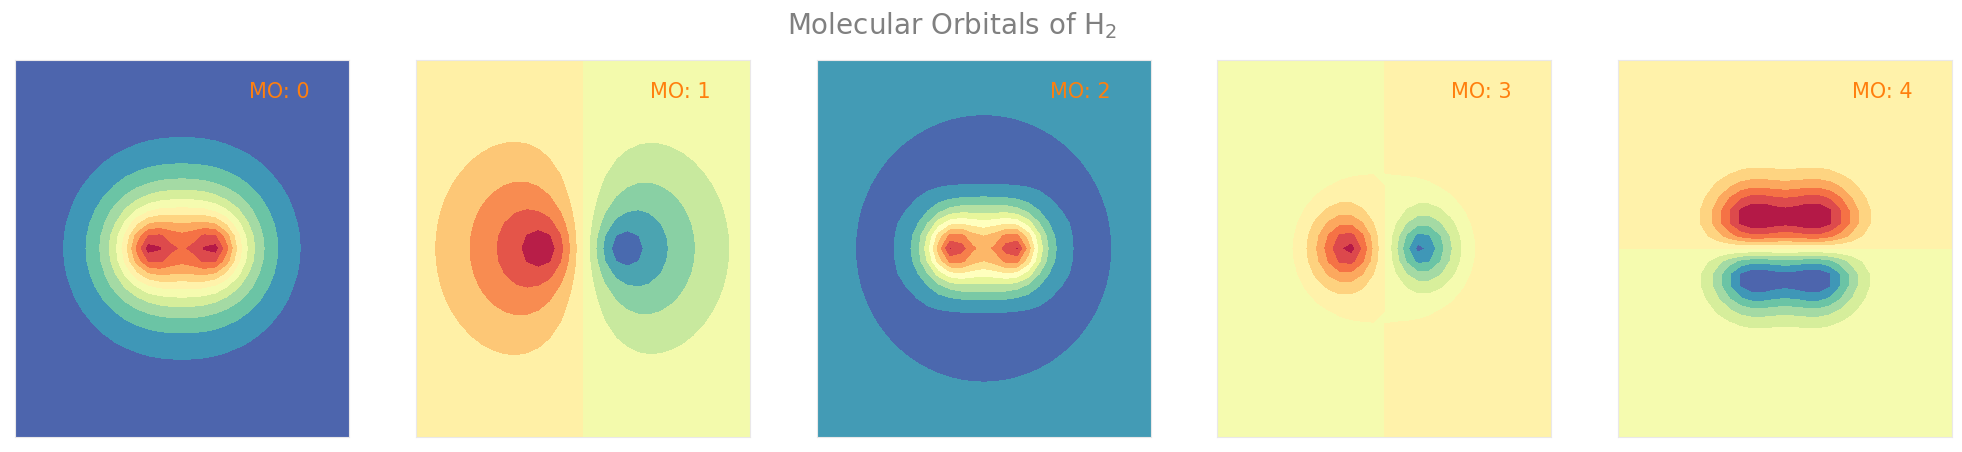

In [16]:
# Or if you prefer a more traditional approach with blobs, try the contourf option. 
fig, ax = plt.subplots( 1, 5, figsize=(25,5) , dpi=100)

fig.suptitle("Molecular Orbitals of H$_2$", fontsize=20)
#     fig.suptitle(t, fontsize=20)
for j, iax in enumerate(ax):
    iax.contourf(orbitals[j,16,:,:], levels=11, cmap="Spectral_r")
    iax.text(21,27, f"MO: {j}", color='tab:orange', fontsize=15)

    iax.set_xticks([])
    iax.set_yticks([])

---
# References

- Becke, A.D., J. Chem. Phys., 1988, 88, 2547  
- Treutler, O. and Ahlrichs, R., J. Chem. Phys., 1995, 102, 346
- Gill, P.M.W., Johnson, B.G., and Pople, J.A., Chem. Phys. Lett., 1993, 209, 5